# Notebook Configurations

In [1]:
import sys

# configuring path and python version for jupyter
sys.executable = '/Users/jacquelinemitchell/opt/anaconda3/envs/openwpm/bin/python3'
sys.path = ['', '/Users/jacquelinemitchell/opt/anaconda3/envs/openwpm/lib/python38.zip', '/Users/jacquelinemitchell/opt/anaconda3/envs/openwpm/lib/python3.8', '/Users/jacquelinemitchell/opt/anaconda3/envs/openwpm/lib/python3.8/lib-dynload', '/Users/jacquelinemitchell/opt/anaconda3/envs/openwpm/lib/python3.8/site-packages']

# Imports

In [2]:
import pandas as pd
import tldextract
import math
import collections
import numpy as np
import matplotlib.pyplot as plt

import sqlite3

## Constants

In [3]:
HTTP_REQS_Q = "SELECT visit_id, url from http_requests"
COOKIES_Q = "SELECT visit_id, host FROM javascript_cookies"
API_CALLS_Q = "SELECT visit_id, document_url FROM javascript"

## Get the Top 100 Sites

In [4]:
top_sites = pd.read_csv('~/Downloads/top-1m.csv', nrows=100, header=None)
sites = top_sites.loc[:, 1].values

## Helper Functions

In [5]:
def is_third_party(domain, url):
    domain_ext = tldextract.extract(domain)

    url_ext = tldextract.extract(url)

    # if the url and the domain are the same, then the url is not from a third party
    if '.'.join(domain_ext[:]) == '.'.join(url_ext[:]):
        return False

    return True

In [6]:
def query_third_parties(query, c):
    
    third_parties = []
    calling_websites = []
    
    for row in c.execute(query):
        visit_id = row[0] - 1
        url = row[1]
        
        ext = tldextract.extract(url)
        url = '.'.join(ext[1:])
    
        if is_third_party(sites[visit_id], url):
            third_parties.append(url)
            calling_websites.append(sites[visit_id])
    
    return third_parties, calling_websites

In [69]:
def compare_plot(web_van, web_ab, c1, c2, category):
    
    # top 100 sites
    num_webs_van = list(collections.Counter(web_van).values())
    num_webs_ab = list(collections.Counter(web_ab).values())
    
    webs_van_plot = [0] * 100
    webs_van_plot[0:len(num_webs_van)] = num_webs_van.copy()
    
    webs_ab_plot = [0] * 100
    webs_ab_plot[0:len(num_webs_ab)] = num_webs_ab.copy()
    
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(25, 10))
    
    ax0.hist(webs_van_plot, color=c1, bins='auto', rwidth=0.5, alpha=0.5, log=False)
    ax0.set_title('Use of 3rd Party {} in Vanilla Mode'.format(category), fontsize=20)
    ax0.set_xlabel('Number of 3rd Party {}'.format(category), fontsize=15)
    ax0.set_ylabel('Frequency', fontsize=15)
    
    ax1.hist(webs_ab_plot, color=c2, bins='auto', rwidth=0.5, alpha=0.5, log=False)
    ax1.set_title('Use of 3rd Party {} in Adblock Mode'.format(category), fontsize=20)
    ax1.set_xlabel('Number of 3rd Party {}'.format(category), fontsize=15)
    ax1.set_ylabel('Frequency', fontsize=15)
    
    plt.show()

In [18]:
def plot(webs, color):
    num_webs_van = list(collections.Counter(webs).values())

    webs_van_plot = [0] * 100
    webs_van_plot[0:len(num_webs_van)] = num_webs_van.copy()
    
    plt.hist(webs_van_plot, color=color, bins='auto', rwidth=0.5, alpha=0.5, log=False)
    plt.show()

In [8]:
def get_top_10(tp_domains):
    return collections.Counter(tp_domains).most_common(10)

## Set Up SQLite DB Connections

In [10]:
# vanilla crawl
van_conn = sqlite3.connect('/Users/jacquelinemitchell/Documents/MachineLearning/WebCrawler/vanilla_sqlite_results/crawl-data.sqlite')
vc = van_conn.cursor()

# ad-block crawl
ab_conn = sqlite3.connect('/Users/jacquelinemitchell/Documents/MachineLearning/WebCrawler/adblock_sqlite_results/crawl-data.sqlite')
ac = ab_conn.cursor()

# HTTP Requests

### Vanilla

In [11]:
tp_https_van, webs_http_van = query_third_parties(HTTP_REQS_Q, vc)

In [29]:
t10_tp_https_van = get_top_10(tp_https_van)

##### Explanations of the Top 10 Third Party Domains (HTTP Requests, Vanilla):

1. ssl-images-amazon.com : address for images on Amazon pages (maybe for amazon ads?)
2. doubleclick.net : ad-serving business owned by Google
3. alicdn.com : Alibaba\'s CDN (content delivery network)
4. msocdn.com : Microsoft Office\'s CDN
5. google.com : Google Search
6. pstatic.net : Owned by Naver (most popular S. Korean browser) - not sure of its purpose
7. cloudfront.net : Amazon's CDN
8. pinimg.com : Pinterest (most likely image content related, from what I could gather)
9. googlesyndication.com : Adsense advertisement network; displays Google ads on pages that contain them
10. awsstatic.com : Owned by Amazon Web Services; static site hosting?

### Ad-Block

In [20]:
tp_https_ab, webs_http_ab = query_third_parties(HTTP_REQS_Q, ac)

In [31]:
t10_tp_https_ab = get_top_10(tp_https_ab)

##### Explanations of the Top 10 Third Party Domains (HTTP Requests, Adblock):

1. ssl-images-amazon.com : address for images on Amazon pages (maybe for amazon ads?)
2. msocdn.com : Microsoft Office\'s CDN (Content delivery network)
3. pstatic.net : Owned by Naver (most popular S. Korean browser) - not sure of its purpose
4. cloudfront.net : Amazon's CDN
5. pinimg.com : Pinterest (most likely image content related, from what I could gather)
6. sinaimg.cn : Seems to be related to Sina Corp. (Chinese tech company), directs a lot of traffic to Sina's website
7. qhimg.com : Not sure entirely what it does, but upon some digging, it seems to work with AWS and Amazon Cloudfront (source: https://webtechsurvey.com/website/s0.qhimg.com/technologies)
8. awsstatic.com : Owned by Amazon Web Services; static site hosting?
9. csdnimg.cn : Seems to be related to TaoBao (Chinese shopping website)
10. twimg.com : Twitter's image-hosting domain

### Compare Plots

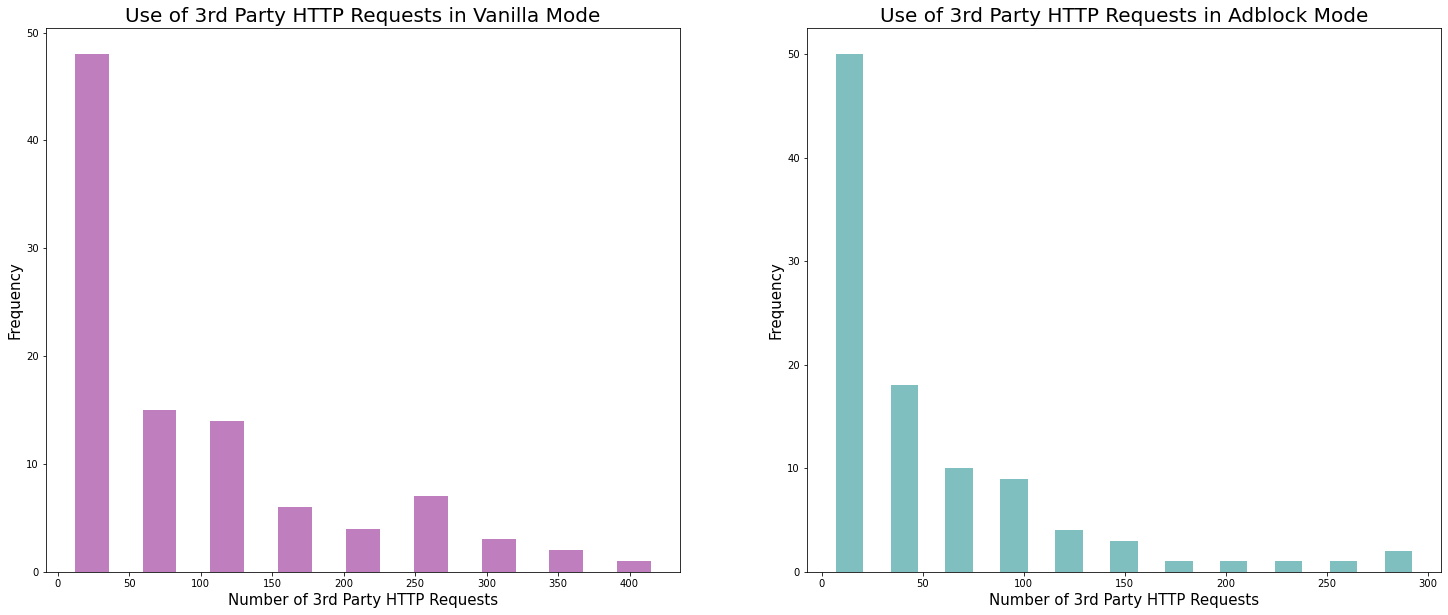

In [75]:
compare_plot(web_van=webs_http_van, web_ab=webs_http_ab, c1='purple', c2='teal', category='HTTP Requests')

### Analysis of the Plots

- In the ad-blocking plot (teal) there is a consistent decline in the frequency of large numbers of 3rd party HTTP requests. In the vanilla plot (purple), there is a noted uptick in frequency when looking at value of around 250 3rd party HTTP requests.  
- The vanilla plot had much more top-100 sites that made many 3rd party HTTP requests than the adblock plot (especially looking in the 150-300 range on both plots).  
- In the vanilla plot, there are top 100 sites that made more than 400 3rd party HTTP requests, but in the adblock plot, there are no top-100 sites that did this.  In fact, the largest number of third party HTTP request by a top-100 site did not break 300 requests.

# Cookies

### Vanilla

In [33]:
tp_cookies_van, webs_cookies_van = query_third_parties(COOKIES_Q, vc)

In [35]:
t10_tp_cookies_van = get_top_10(tp_cookies_van)

##### Explanations of the Top 10 Third Party Domains (Cookies, Vanilla):

1. demdex.net : Owned by adobe; captures/stores behavioral data on behalf of websites/advertisers
2. yahoo.com : Search engine, but not sure quite what the purpose is here... Advertising?
3. pubmatic.com : programmatic advertising
4. doubleclick.net : Google-owned; adserving platform
5. rubiconproject.com : automated buying/selling of advertising; owns one of largest real-time cloud & big data computing systems
6. casalemedia.com : uses cookies to track whether a user has seen an ad or not
7. amazon.com : maybe related to AWS/advertisements?
8. adsrvr.org : ad serving platform
9. rlcdn.com : sends web beacons (usually invisibly checking that a user has accessed certain content); provides data about email addresses and users behind them; targeted marketing and profiling
10. amazon-adsystem.com : online ads on the Amazon network; used to drive traffic/boost sales

### Ad-Block

In [42]:
tp_cookies_ab, webs_cookies_ab = query_third_parties(COOKIES_Q, ac)

In [43]:
t10_tp_cookies_ab = get_top_10(tp_cookies_ab)

##### Explanations of the Top 10 Third Party Domains (Cookies, Ad-Block):

1. amazon.com : maybe related to AWS?
2. taboola.com : content discover and native advertising
3. youtube.com : load YouTube media content? (load youtube ads?) (Youtube has an api for ads and third party content serving)
4. sina.cn : Chinese tech company
5. microsoft.com : Microsoft has various services for websites
6. aliexpress.ru : online retail service owned by Alibaba
7. tmall.ru : website for business to consumer online retail, owned by Alibaba
8. google.com : google search / google APIs?
9. live.com : url used by Microsoft for OneDrive and Outlook services
10. bing.com : bing search engine

### Compare Plots

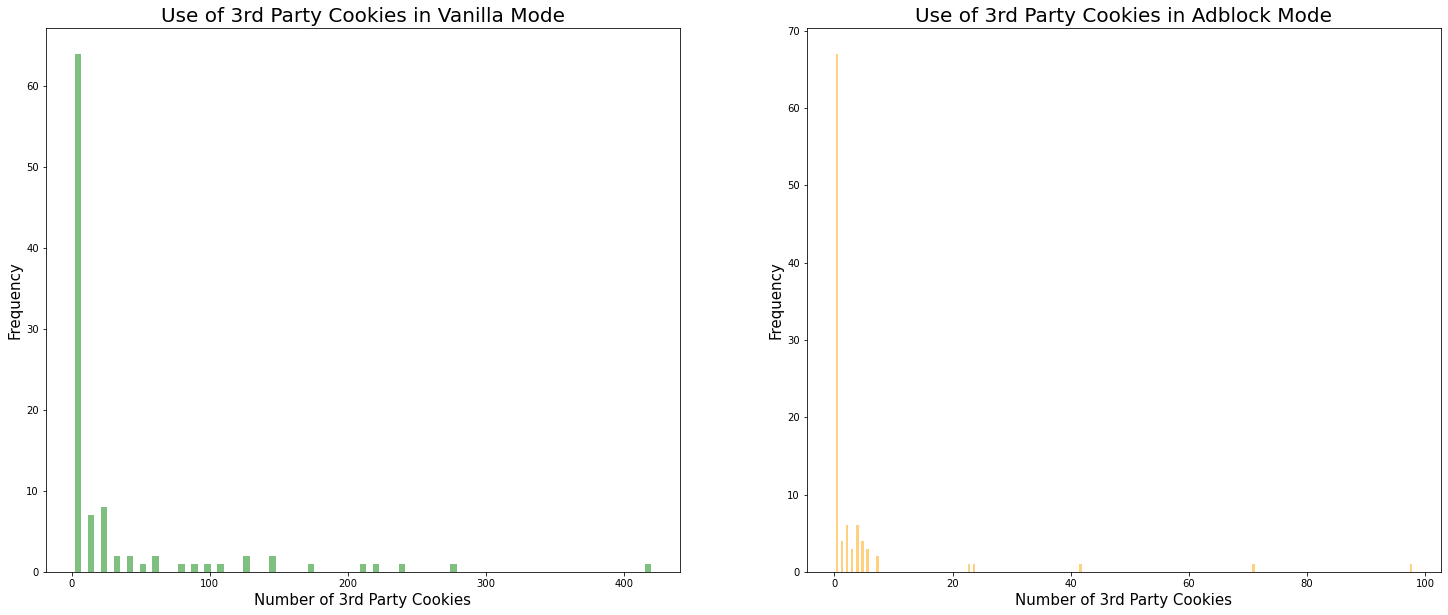

In [71]:
compare_plot(web_van=webs_cookies_van, web_ab=webs_cookies_ab, c1='green', c2='orange', category='Cookies')

### Analysis of the Plots

- The vanilla plot (green) had a much larger right tail in its distribution.  There were many more large numbers of 3rd party cookies stored compared to the adblock plot (orange).  The largest amount of 3rd party cookies stored exceeded 400 on the vanilla plot, but on the adblocking plot the largest number of 3rd party cookies stored did not exceed 100
- In the adblock mode, the majority of the distribution is concentrated in a relatively small number of 3rd cookies (compared to the vanilla plot), below 20 3rd party cookies.

# JS API Calls

### Vanilla

In [45]:
tp_api_calls_van, webs_api_calls_van = query_third_parties(API_CALLS_Q, vc)

In [50]:
t10_tp_api_calls_van = get_top_10(tp_api_calls_van)

##### Explanations of the Top 10 Third Party Domains (API Calls, Vanilla):

1. 2mdn.net : used to deliver doubleclick ads
2. google.com : google search/ads?
3. youtube.com : Youtube has an api for ads and third party content serving / load YouTube ads?
4. microsoft.com : Microsoft ad services / Azure?
5. amazon.com : amazon ads / AWS
6. baidu.com : the dominant Chinese search engine
7. alicdn.com : Alibaba's CDN (content delivery network)
8. rubiconproject.com : automated buying/selling of advertising; owns one of largest real-time cloud & big data computing systems
9. doubleclick.net : ad-serving business owned by Google
10. bbc.com : public service broadcaster

### Ad-Block

In [54]:
tp_api_calls_ab, webs_api_calls_ab = query_third_parties(API_CALLS_Q, ac)

In [56]:
t10_tp_api_calls_ab = get_top_10(tp_api_calls_ab)

##### Explanations of the Top 10 Third Party Domains (API Calls,  Ad-Block):

1. youtube.com : load YouTube media (i.e. videos, perhaps ads?)
2. amazon.com : AWS, load e-commerce data
3. microsoft.com : Micrsoft has many web APIs for different purposes
4. google.com : Google search / Google developer tools (Google has site APIs too)
5. facebook.com : social media
6. csdnimg.cn : Seems to be related to TaoBao (Chinese shopping website)
7. qualaroo.com : user research and customer feedback
8. googleblog.com : blog publisher owned by Google
9. streamable.com : video streaming services for bloggers and publishers
10. bitly.com : url-shortnening platform

### Compare Plots

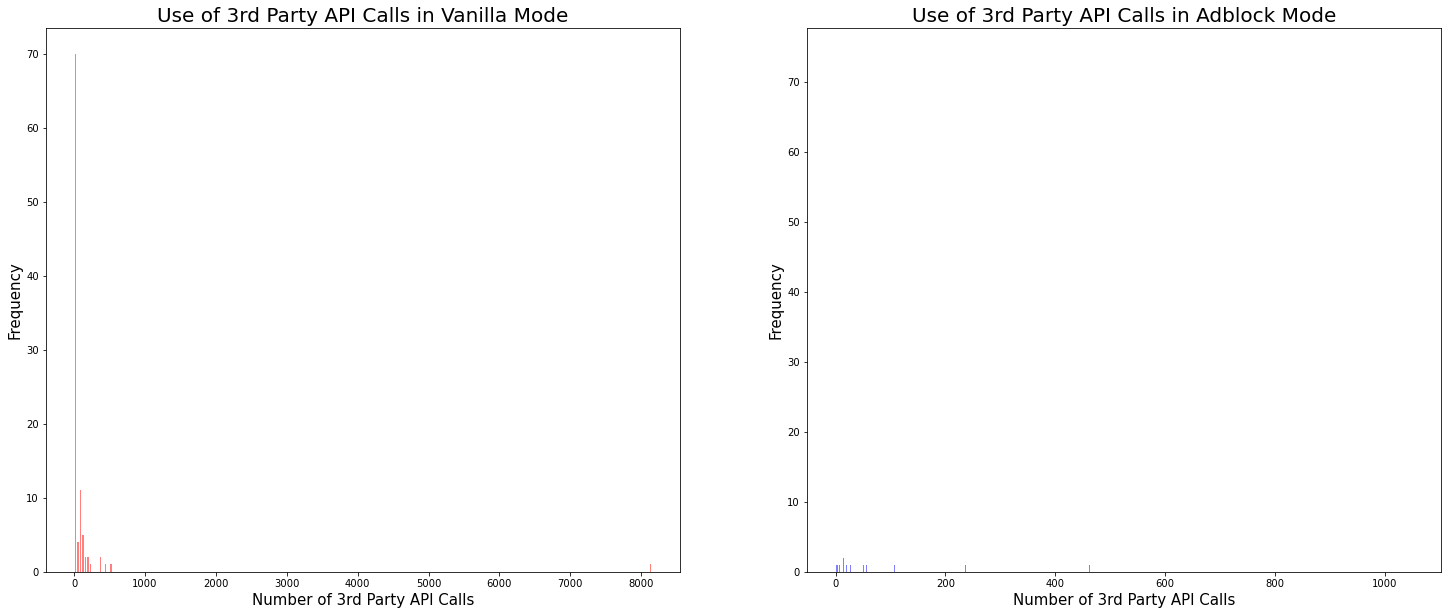

In [72]:
compare_plot(web_van=webs_api_calls_van, web_ab=webs_api_calls_ab, c1='red', c2='blue', category='API Calls')

### Analysis of the Plots

- The difference between the vanilla plot (red) and the adblock plot (blue) are stark here.  The vanilla plot had many more 3rd party API calls than the adblock plot. Looking at the frequencies, the vanilla plot had many more top-100 websites that made any number of 3rd party API calls than the adblock plot.
- The range of the number of 3rd party API calls any top-100 site made is much more vast on the vanilla plot, with the concentrated area of the vanilla plot convering the entire horizontal range of the adblock block.